# Tutorial 3: Data-driven discovery of Lorenz system: Multilayer Perceptrons

#### Author: Taku Ito

7/7/2025

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import tutorial_ddd
import tutorial_ddd.lorenz
%matplotlib inline
%load_ext autoreload
%autoreload 2


#### Experiment: We want to infer the governing differential equations (e.g., $\dot{x}$, $\dot{y}$, $\dot{z}$) from $x$, $y$, and $z$ using a multilayer perceptron
* So, we want to infer the derivatives using the linear combination of features of $x$, $y$, and $z$.
* MLPs are universal function approximators (Elman, 1990), so they can learn any function $y = f(X)$, but the components/bases of $f$ will be difficult to interpret

Practically, suppose we want to predict $Y = [ \dot{x}, \dot{y}, \dot{z} ]$. To train our MLP, we will learn a simple MLP $f$ that maps $X = [x, y, z]$ to $Y$, i.e., $Y = f(X)$. We can then assess how well the learned $f$ can be used to simulate/reproduce the Lorenz system under new initial conditions.

#### 3.1: Simulate Lorenz time series with specified parameters

In [ ]:
#### Define initial conditions and parameters and simulate
import tutorial_ddd.models


initial_conditions = [0.1, 0.0, 0.0]  # Starting point [x, y, z]
sigma_val = 10.0
rho_val = 28.0
beta_val = 8/3
delta_t = 0.01
total_steps = 20000 # More steps to see the chaotic attractor

print(f"Simulating Lorenz system with initial conditions: {initial_conditions}")
print(f"Parameters: sigma={sigma_val}, rho={rho_val}, beta={beta_val}")
print(f"Time step (dt): {delta_t}, Number of steps: {total_steps}")

# Simulate the system
lorenz_trajectory, derivatives = tutorial_ddd.lorenz.simulate_lorenz(
    initial_conditions,
    sigma=sigma_val,
    rho=rho_val,
    beta=beta_val,
    dt=delta_t,
    num_steps=total_steps
)


noise_amplitude = 0 # 1
noise = np.random.normal(0,noise_amplitude,lorenz_trajectory.shape)
lorenz_trajectory = lorenz_trajectory + noise

Simulating Lorenz system with initial conditions: [0.1, 0.0, 0.0]
Parameters: sigma=10.0, rho=28.0, beta=2.6666666666666665
Time step (dt): 0.01, Number of steps: 20000


#### 3.2: Initialize and train MLP (one hidden-layer) on Lorenz data

In [8]:
##### Import Pytorch
import torch
torch.manual_seed(701)

## Instantiate MLP with single hidden layer
y = derivatives
X = lorenz_trajectory.copy()
model = tutorial_ddd.models.MLP(ndim=32, nlayers=1, input_size=X.shape[1], output_size=y.shape[1])

# specify loss function (MSE)
MSE = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0001, weight_decay=1.0)
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
batch_size = 512
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 500
dataframe = {}
dataframe['Loss'] = []
dataframe['Epoch'] = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_Y in dataloader:
        # set gradients to 0 before computing them again
        optimizer.zero_grad()

        # compute predictions
        output = model(batch_X)

        # calculate loss
        loss = MSE(output, batch_Y)

        # Backward pass, compute gradients + update weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0) # compute overall loss
    
    # Normalize loss per epoch
    epoch_loss = epoch_loss / len(dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}")
    dataframe['Loss'].append(epoch_loss)
    dataframe['Epoch'].append(epoch)

import pandas as pd
dataframe = pd.DataFrame(dataframe)

Epoch 1, Loss: 2.799795742034912
Epoch 11, Loss: 0.14475089728832244
Epoch 21, Loss: 0.09846274687051773
Epoch 31, Loss: 0.08059668466448784
Epoch 41, Loss: 0.07124178037643433
Epoch 51, Loss: 0.06176029813289642
Epoch 61, Loss: 0.05587218668460846
Epoch 71, Loss: 0.05173889023065567
Epoch 81, Loss: 0.048378487554192544
Epoch 91, Loss: 0.04554720005989075
Epoch 101, Loss: 0.04333180293738842
Epoch 111, Loss: 0.040518394470214845
Epoch 121, Loss: 0.03764715998768806
Epoch 131, Loss: 0.03532261508703232
Epoch 141, Loss: 0.03335224170386791
Epoch 151, Loss: 0.03133003122508526
Epoch 161, Loss: 0.029656681755185127
Epoch 171, Loss: 0.028089274671673773
Epoch 181, Loss: 0.026729028540849686
Epoch 191, Loss: 0.02529380573630333
Epoch 201, Loss: 0.024044828367233276
Epoch 211, Loss: 0.022934363922476768
Epoch 221, Loss: 0.021848963642120363
Epoch 231, Loss: 0.020828647205233575
Epoch 241, Loss: 0.019827380660176277
Epoch 251, Loss: 0.018962115547060968
Epoch 261, Loss: 0.018164923410117627
Ep

#### 2.4: Evaluate model fit: Compute Lorenz system using the learned model

In [9]:
def simulateEstimatedLorenzWithMLP(model, x0, y0, z0, num_steps=20000):
    """
    """
    trajectory = torch.zeros(num_steps,3)
    trajectory[0] = torch.tensor([x0, y0, z0])
    for t in range(num_steps-1):
        dxdt = model(trajectory[t]) 
        # print(dxdt)
        new_val = trajectory[t] + dxdt
        trajectory[t+1] = new_val
    return trajectory.detach().numpy()

model_trajectory = simulateEstimatedLorenzWithMLP(model, initial_conditions[0], initial_conditions[1], initial_conditions[2])

#### 2.5: Compare the original Lorenz system with the learned model from a model 

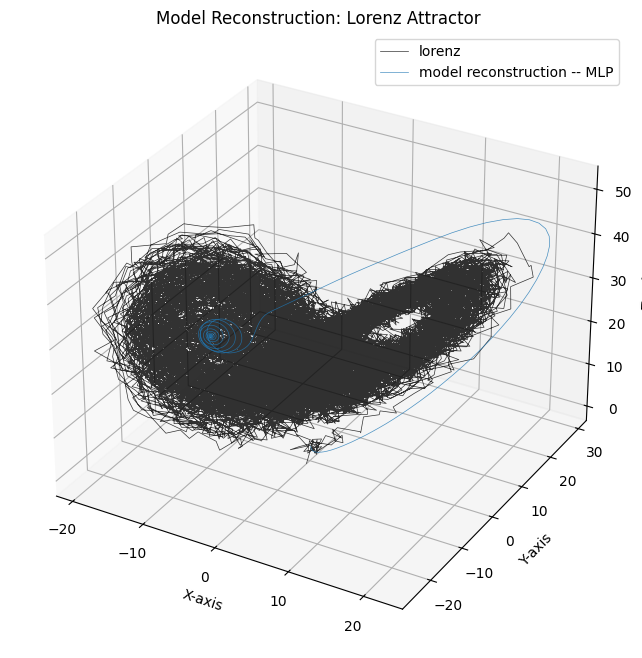

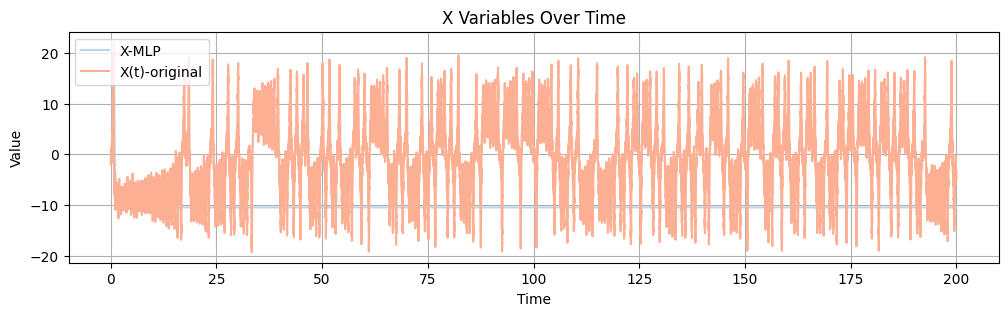

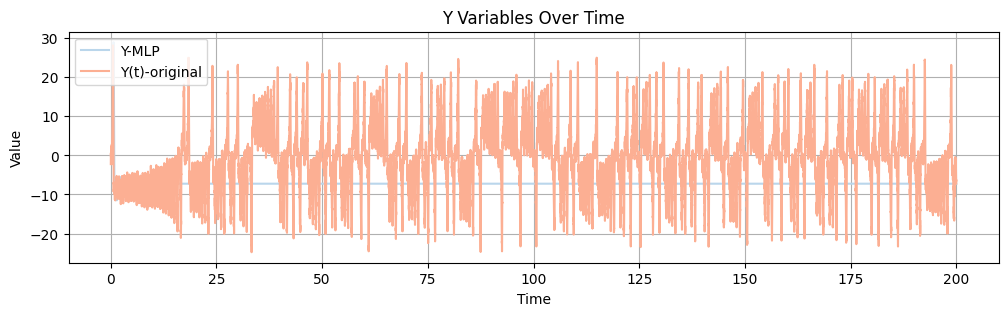

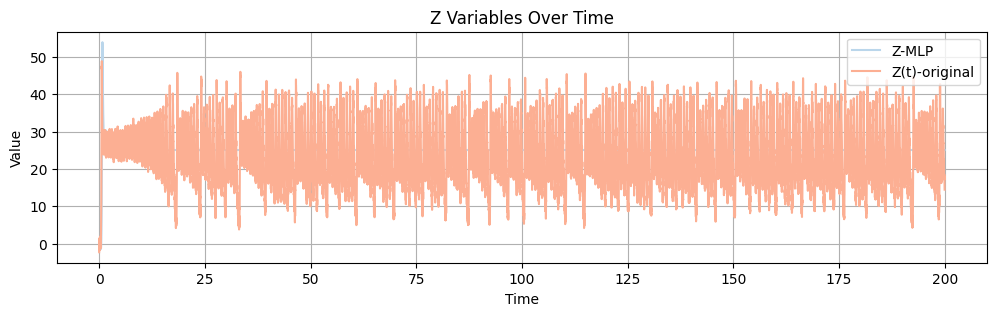

In [11]:
import seaborn as sns
# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(lorenz_trajectory[:, 0], lorenz_trajectory[:, 1], lorenz_trajectory[:, 2], lw=0.5, alpha=0.8, color='black', label='lorenz')
ax.plot(model_trajectory[:, 0], model_trajectory[:, 1], model_trajectory[:, 2], lw=0.5, alpha=0.8, label='model reconstruction -- MLP')
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Model Reconstruction: Lorenz Attractor")
plt.legend()

# You can also plot individual dimensions against time
plt.figure(figsize=(12, 3))
time_points = np.arange(0, total_steps * delta_t, delta_t)
plt.plot(time_points, model_trajectory[:, 0], label='X-MLP', color=sns.color_palette('Blues')[1])
plt.plot(time_points, lorenz_trajectory[:, 0], label='X(t)-original', color=sns.color_palette('Reds')[1])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("X Variables Over Time")
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 3))
time_points = np.arange(0, total_steps * delta_t, delta_t)
plt.plot(time_points, model_trajectory[:, 1], label='Y-MLP', color=sns.color_palette('Blues')[1])
plt.plot(time_points, lorenz_trajectory[:, 1], label='Y(t)-original', color=sns.color_palette('Reds')[1])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Y Variables Over Time")
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 3))
time_points = np.arange(0, total_steps * delta_t, delta_t)
plt.plot(time_points, model_trajectory[:, 2], label='Z-MLP', color=sns.color_palette('Blues')[1])
plt.plot(time_points, lorenz_trajectory[:, 2], label='Z(t)-original', color=sns.color_palette('Reds')[1])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Z Variables Over Time")
plt.legend()
plt.grid(True)